# Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

# Draw some blends

We'll first explore the image generation part of BTK. We need to provide 3 main elements: the catalog, a sampling function, and a survey.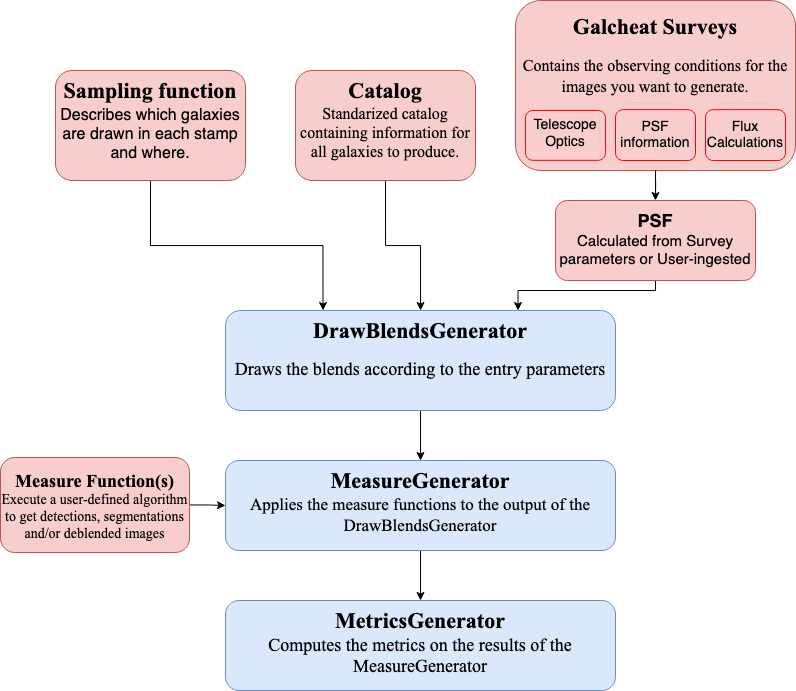


## Catalog

BTK uses a wrapper class for the actual catalog object, to get a standardized input for the generator. Currently, BTK supports two kinds of catalogs: Catsim-like catalogs and the COSMOS catalog (as provideed with Galsim). Both have their own implementation of the `Catalog` class; we will only use the Catsim one here. You can easily import the catalog from a FITS file using the `from_file` method as demonstrated here with our example catalog.

In [2]:
catalog_name = "/Users/matt/Desktop/UCI_Research/LSST/btk_blending/DS_creation/Data/OneDegSq.fits"
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)

When the Catalog object is created, it creates internally a `table` attribute containing a modified table from the input, which will be used in the rest of the code.

In [3]:
catalog.table

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab,ref_mag,btk_size
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2200871446,1505.9509277292,-0.5342399817876,0.496377289295,0.0,1.4144730572e-17,0.0,0.0,0.278649687767,0.0,0.221303001046,0.0,307.344329834,25.9418621063,25.129743576,23.9588813782,23.3607368469,23.0723800659,22.9095973969,23.3607368469,1.29850754499422
2205921112,1512.1024131744,-3.609359823168,1.89508104324,0.0,1.91501907101e-18,0.0,0.0,0.358063697815,0.0,0.313674807549,0.0,137.791702271,25.848903656,25.867565155,25.9179477692,25.9851398468,25.8779563904,25.7642536163,25.9851398468,1.6685768318179002
2205010878,1524.3564605652,-11.266919877384,1.93795013428,0.0,2.15612608955e-18,0.0,0.0,0.444279909134,0.0,0.424689114094,0.0,233.972427368,25.5657653809,25.5659580231,25.6165962219,25.6957893372,25.6281528473,25.5399188995,25.6957893372,2.07034437656444
2208734677,1515.910291668,-0.26135999942183996,1.16251754761,0.0,1.74001598433e-18,0.0,0.0,0.312852591276,0.0,0.180962398648,0.0,217.517120361,27.3159255981,27.4167633057,27.051820755,26.6737632751,25.9380722046,25.6458129883,26.6737632751,1.45789307534616
2212241881,1523.4518051136,-7.851959858088,1.35479903221,0.0,1.11031595423e-18,0.0,0.0,0.414316505194,0.0,0.205554202199,0.0,226.523849487,27.3325939178,27.4470024109,27.3282527924,27.0680370331,26.7419490814,26.1817016602,27.0680370331,1.93071491420404
2204477290,1521.3000297564001,-2.1744000026964,1.33114361763,0.0,5.75775484903e-18,0.0,0.0,0.351797997952,0.0,0.126827403903,0.0,53.955165863,25.6527175903,25.7753200531,25.4755821228,25.2793464661,24.9572029114,24.4631252289,25.2793464661,1.63937867045632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402715331570,1295550.6201252,1694.7615981096,1.13901436329,0.0,6.89243489121e-19,0.0,0.0,0.237239196897,0.0,0.0846088975668,0.0,179.666900635,28.4756774902,28.5343647003,27.9942626953,27.6640815735,26.918012619,26.7960968018,27.6640815735,1.10553465754002
402700244654,1295550.8274096001,1691.8077349656,0.648103415966,3.45350585806e-17,6.23718269364e-17,0.0,0.315796494484,0.389489203691,0.315575987101,0.130392700434,205.661132812,205.661132812,24.8195457458,23.8537445068,22.7531909943,21.8946380615,21.5558547974,21.2948169708,21.8946380615,1.4819087767866106


## Sampling Function

The sampling function is an object which is used to determine the information about the blends, e.g. which galaxies are drawn, with what shifts, etc. This is achieved using the `SamplingFunction` class, which is callable like a function, taking the `Catalog.table` as an argument and returning modified selected entries corresponding to the galaxies being drawn.

For this tutorial, we'll use the default sampling function, which can be instantiated like so:

In [4]:
stamp_size = 24.0 # Size of the stamp, in arcseconds
max_number = 2 # Max number of galaxies in a blend
max_shift = 3.0 # Max shift of the galaxies from center, in arcseconds
sampling_function = btk.sampling_functions.DefaultSampling(max_number=max_number,
                                                          stamp_size=stamp_size,
                                                          maxshift=max_shift)

This function chooses random galaxies (after applying a mag cut), computes random shifts for the galaxies and returns the entries from the table, adding two columns corresponding to the shifts.

# Survey
BTK relies on the [galcheat](https://github.com/aboucaud/galcheat) package, which contains several `galcheat.Survey.Surveys` instances, which store the parameters for different surveys (including LSST, HSC, HST COSMOS, etc.). The parameters represent physical parameters of the survey (mirror size, pixel scale). Each survey also contains several `galcheat.filter.Filter` objects with the parameters specific to each filter (exposure time, zeropoint). Those objects can easily be imported in BTK using the following function and the name of the survey.

Internally, the `btk.survey.Survey` object and the `btk.filter.Filter` object are used because they can be modified by the user (galcheat objects cannot) and contain an additional PSF attribute. For this tutorial, we will import the survey corresponding to LSST

In [5]:
LSST = btk.survey.get_surveys("LSST")

The `psf` attribute deserves an additional explanation: **it corresponds to the PSF for each filter**. It is added via the `get_surveys` function. The user may provide a `psf` argument, which should be callable and takes a survey and filter as arguments and returns a galsim object. For instance:

In [6]:
import galsim

def custom_psf(survey, filtr):
    return galsim.Kolmogorov(fwhm=filtr.psf_fwhm.to_value("arcsec"))

LSST_custom = btk.survey.get_surveys("LSST", custom_psf)

If no `psf` argument is provided, a default PSF (taking into account optical and atmospheric effects) will be used.

A more advanced possibility is to have your `custom_psf` function return a callable which in turn returns a galsim object. This callable will be called for each batch, allowing the user to randomize the PSF for instance:

In [7]:
def custom_psf(survey, filtr):
    def random_psf():
        return galsim.Kolmogorov(fwhm=filtr.psf_fwhm.to_value("arcsec")
                                 +np.random.uniform(-0.1,+0.1)) # Randomize the FWHM
    return random_psf

LSST_custom = btk.survey.get_surveys("LSST", custom_psf)

## Draw Blends

Now that we have all the objects at our disposal, we can create the *DrawBlendsGenerator*. This object is a python generator, meaning it can be called with `next(generator)` to generate a new batch. It is designed for Catsim and COSMOS, and we will use the Catsim one here.

In [8]:
draw_generator = btk.draw_blends.CatsimGenerator(
    catalog=catalog,
    sampling_function=sampling_function,
    surveys=LSST_custom,
    batch_size=10,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all", 
    seed=1)

The results from the `next` call are stored in a dictionary; the keys are:

- `blend_images`: for the actual images (as a np.array of shape `(batch_size, stamp_size, stamp_size, len(survey.filters))`
- `isolated_images`: for the isolated images (as a np.array of shape `(batch_size, sampling_function.max_number, stamp_size, stamp_size, len(survey.filters))`
- `blend_list`: for the blend information (as a list of astropy tables corresponding to the output of the sampling function for each blend)
- `psf` for the PSF (as a list of Galsim objects)
- `wcs` for the World Coordinate System corresponding to the images (as a list of `astropy.wcs.WCS` objects)

Please note that several surveys can be provided as a list to the generator. In that case, each of the entries will contain a dictionary indexed by the surveys, which in turn contains the results described above (you would access it with `batch['blended_images']['LSST']` for example).

**Note:** Fluxes in BTK for these images are calculated using `galcheat` based on the function: `~galcheat.utilities.mag2counts` function and corresponding survey and filter parameters. Please see the `galcheat` [documentation](https://aboucaud.github.io/galcheat/index.html) for more details.

In [9]:
batch = next(draw_generator)
blend_images = batch['blend_images']
blend_list = batch['blend_list']
isolated_images = batch['isolated_images']
indx = 2    # Sample number

Generating blends for LSST survey:   0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Isolated image 2')

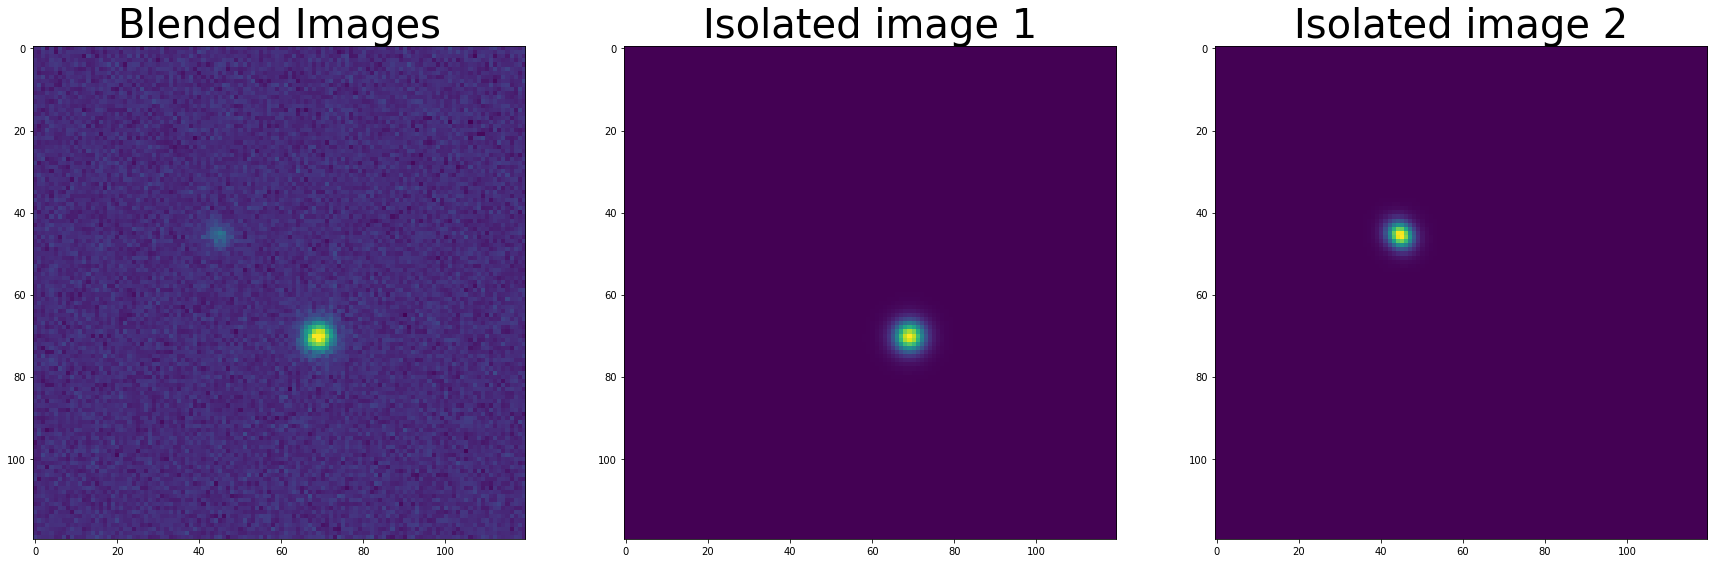

In [10]:
indx = 2# Sample number
cindx = 2   # Channel index (band number has 6 filters for LSST)
oindx = 0   # Object index (for the isolated images)

fig, axes = plt.subplots(1, 3, figsize=(30,26))

axes[0].imshow(blend_images[indx][cindx])
axes[0].set_title('Blended Images', fontsize=40)
axes[1].imshow(isolated_images[indx][oindx][cindx])
axes[1].set_title('Isolated image 1', fontsize=40)
axes[2].imshow(isolated_images[indx][oindx+1][cindx])
axes[2].set_title('Isolated image 2', fontsize=40)

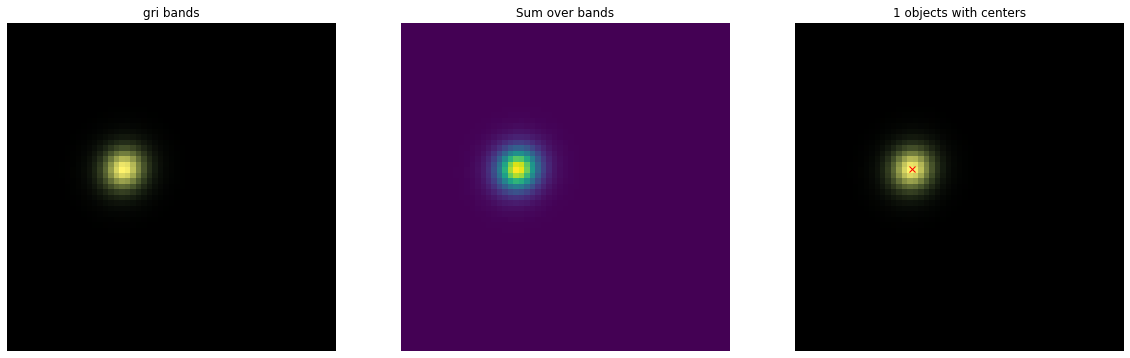

In [18]:
btk.plot_utils.plot_blends(blend_images[:indx],
                           blend_list[:indx],
                           limits=(30,90))

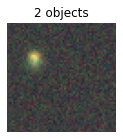

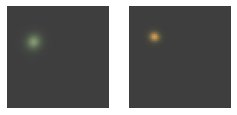

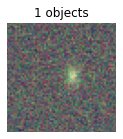

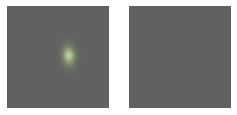

In [12]:
btk.plot_utils.plot_with_isolated(blend_images=blend_images[:indx],
                                 isolated_images=isolated_images[:indx],
                                 blend_list=blend_list[:indx],
                                 limits=(30,90))

In [13]:
print("Blended images shape =", blend_images.shape)
print("Isolated images shape =", isolated_images.shape)

Blended images shape = (10, 6, 120, 120)
Isolated images shape = (10, 2, 6, 120, 120)


In [14]:
blend_images.shape

(10, 6, 120, 120)

### Noiseless samples

Generating blends for LSST survey:   0%|          | 0/1 [00:00<?, ?it/s]

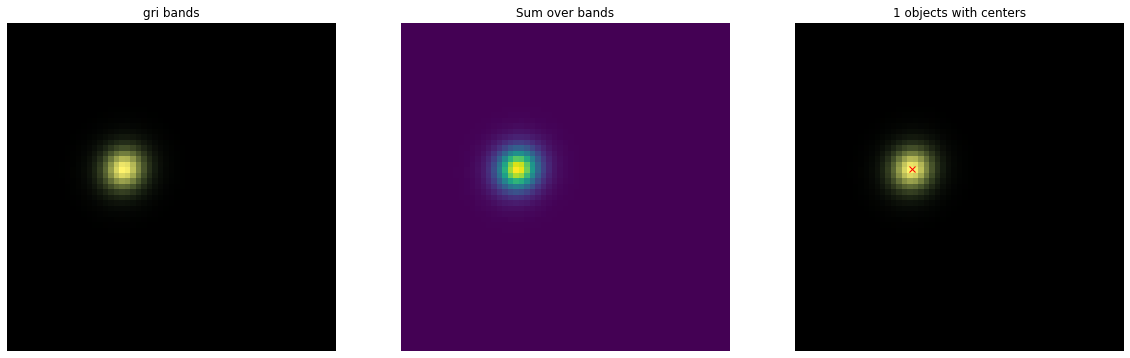

In [15]:
draw_generator = btk.draw_blends.CatsimGenerator(
    catalog=catalog,
    sampling_function=sampling_function,
    surveys=LSST_custom,
    batch_size=1,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="none",
    seed=1)

batch = next(draw_generator)
blend_images = batch['blend_images']
blend_list = batch['blend_list']
isolated_images = batch['isolated_images']
indx = 1

btk.plot_utils.plot_blends(blend_images[:indx], blend_list[:indx], limits=(30,90))

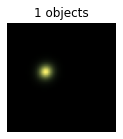

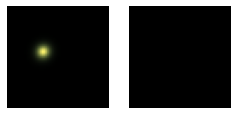

In [16]:
btk.plot_utils.plot_with_isolated(blend_images=blend_images[:indx],
                                 isolated_images=isolated_images[:indx],
                                 blend_list=blend_list[:indx],
                                 limits=(30,90))